In [2]:
import deepsudoku
import os
import gymnasium as gym
import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import deepsudoku.reinforcement_learning
from captum.attr import IntegratedGradients

os.chdir(deepsudoku.REPO_PATH)

from reinforcement_exp.single_action_architectures import *

Sudoku Environment avaible at gymnasium as 'Sudoku-v0'.


/home/mindset/miniconda3/envs/drl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
env = gym.make("Sudoku-x2")

agent = OnlyConvSeperateValue(True)
agent.load_state_dict(torch.load("reinforcement_exp/runs/Sudoku-x2__Best_Model_x2_easy__1__1693322907/final_model.pth",
                                    map_location=torch.device('cpu')))

agent.eval()

def wrapper(obs):
    logits = agent.actor(obs.permute(0, 3, 2, 1)).permute(0, 3, 2, 1).reshape(-1, 9**3)
    return logits

ig = IntegratedGradients(wrapper)

obs_, _ = env.reset()
obs = torch.tensor(obs_)[None,:].float()
obs = torch.nn.functional.one_hot(obs.to(torch.int64), 10)
obs = obs.float().requires_grad_(True)

# get actual decision
act = agent.get_greedy_action(torch.tensor(obs_)[None,:].float())

In [6]:
attributions, approximation_error = ig.attribute(obs,
                                                 #baselines=baseline,
                                                 target=act,
                                                 method='gausslegendre',
                                                 return_convergence_delta=True)

In [7]:
skrrt = attributions.squeeze(0).sum(dim=2).detach().numpy()

In [8]:
def plot_attrs(obs, attrs):
    fig, ax = plt.subplots()

    # Create a heatmap-like plot with imshow
    cax = ax.imshow(attrs, cmap='viridis')

    # Add text labels inside each cell
    for i in range(attrs.shape[0]):
        for j in range(attrs.shape[1]):
            ax.text(j, i, str(obs[i, j]), va='center', ha='center', color='white', fontsize=12)

    # Add colorbar for reference
    cbar = fig.colorbar(cax)

    plt.show()

In [13]:
np.unravel_index(act.numpy(),(9,9,9))

(array([7]), array([6]), array([5]))

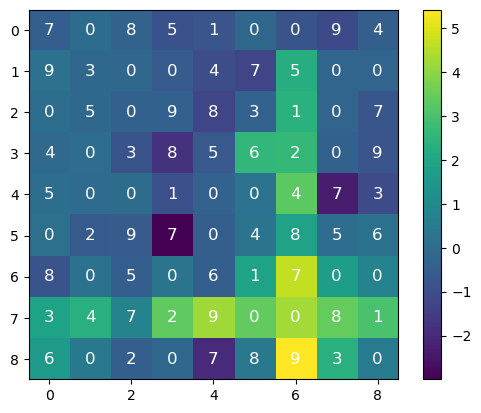

In [12]:
plot_attrs(obs_, skrrt)